# TP Réseaux de Neurones – Séance 3
## Reconnaissance de chiffres manuscrits

### Objectifs
- Charger un dataset de chiffres manuscrits.
- Implémenter un petit réseau de neurones (64 -> 32 -> 10).
- L’entraîner et évaluer sa performance.


## 1. Chargement des données

On va utiliser la bibliothèque Scikit Learn (https://scikit-learn.org/stable/) spécialisée dans l'apprentissage machine. Elle contient de nombreuses fonctionnalités pour les réseaux de neurones mais aussi des jeux de tests, dont celui que noua allons utiliser : l'écriture chiffrée manuscrite.

Il s'agit d'images 8x8 en niveaux de gris d'écritures variées des chiffres de 0 à 9. On a environ 180 variantes d'écritures par classes (chiffres) poru un total de 1797 données. Chacun des 64 pixels est codé avec une valeur entière de 0 à 15 représentant un des 16 niveaux de gris.

Après avoir chargé tout le jeu de données, nous utiliserons une fonction qui va le séparer en deux jeux : un jeu de données qui seriva d'entrainement du réseau et un jeu (inconnu du réseau) que l'on utilisera pour tester la capacité de reconnaissance du réseau.

Mais avant quelques remarques :
- Normalisation : comme souvent en optimisation, pour limiter l'influence de la taille des valeurs numériques, on les normalise afin d'avoir des valeurs dans un même intervalle, souvent [0,1].
- encodage one-hot : ici les étiquettes des données correspondent au chiffre effectivement représenté sur l'image, c'est à dire des valeurs de 0 à 9. Ce choix pourrait induire pour le réseau une notion d'ordre ou de métrique. C'est une des raisons pour lesquelles on utilise un encodage sous forme de vecteur de la manière suivante. Si on a K caractéristiques au total, on utilise un vecteur binaire (0 ou 1) de dimension K. Par exemple ici pour dire que l'image correspond au chiffre 3 (sachant qu'il y en a 10 au total), on va coder l'éthiquette par le vecteur [0,0,0,1,0,0,0,0,0,0]. Cet encodage ne marche que pour des valeurs discrètes.
- Dense / creuse : l'inconvénient du One-Hot est qu'on a des vecteurs et matrices creuses (beaucoup de 0) ce qui surcharge la mémoire pour rien. Heureusement on peut demander à ce que l'encodeur One-Hot retourne un tableau dense.

In [3]:
# On importe la fonction qui charge le jeu de données Digits 
# (images 8×8 de chiffres manuscrits 0–9). 
# Ce dataset contient 1797 images en niveaux de gris

from sklearn.datasets import load_digits

# On importe l’outil pour séparer le jeu de données en train 
# et test de façon aléatoire mais contrôlée.

from sklearn.model_selection import train_test_split

# On importe l’encodeur pour transformer les étiquettes entières 
# (0…9) en vecteurs one-hot de dimension 10 (utile pour les 
# réseaux avec softmax + cross-entropy).

from sklearn.preprocessing import OneHotEncoder

# Les bibliothèques de calcul et d'affichage

import numpy as np
import matplotlib.pyplot as plt

# On charge le dataset dans un objet de type Bunch 
# (un peu comme un dict).
# Propriétés principales :
# - digits.data : tableau (1797, 64) — chaque image 8×8 aplatie en 64 features.
# - digits.images : tableau (1797, 8, 8) — images 2D originales.
# - digits.target : vecteur (1797) — labels entiers de 0 à 9.

digits = load_digits()

# digits.data contient des intensités entre 0 et 16 (inclus).
# On normalise en divisant par 16 pour obtenir des valeurs dans [0, 1].
# Shape : X est (1797, 64).

X = digits.data/16.0

# digits.target est 1D (1797,) ; 
# OneHotEncoder attend une entrée 2D (colonnes = features).
# reshape(-1, 1) transforme en colonne : (1797, 1).
# (Le -1 demande à NumPy d’inférer automatiquement le nombre de lignes.)

y = digits.target.reshape(-1,1)

# On crée l’encodeur one-hot.
# sparse_output=False ⇒ on veut un tableau dense NumPy 
# (et non une matrice clairsemée).

encoder = OneHotEncoder(sparse_output=False)

# On apprend les catégories présentes (0…9) et 
# transforme y en vecteurs one-hot.
# Shape : y_onehot est (1797, 10).
# Exemple :
#       label 3 → [0,0,0,1,0,0,0,0,0,0]
#       label 9 → [0,0,0,0,0,0,0,0,0,1]

y_onehot = encoder.fit_transform(y)

# On sépare les données en 80% train / 20% test.
# random_state=0 rend la découpe reproductible.
# Shapes attendues :
#     X_train : (1437, 64)
#     X_test : (360, 64) (car 20% de 1797 ≈ 360)
#     y_train : (1437, 10)
#     y_test : (360, 10)

X_train,X_test,y_train,y_test = train_test_split(X,y_onehot,test_size=0.2,random_state=0)

## 2. Fonctions utiles

On va réaliser un réseau de neuronnes avec 64 entrées (une par pixel d'image), une couche cachée de 32 neurones et une couche de sortie de 10 neurones, chacun fournissant une sortie 0 ou 1. L'ensemble des 10 sorties fournira le codage One-Hot de l'éthiquette reconnue.

Pour la couche cachée on va utiliser comme fonction d'activation la fonction sigmoïde déjà utilisée dans les TP précédents.

Par contre, pour la couche de sortie on va utiliser une nouvelle fonction d'activation : la fonction softmax. C'est la fonction la plus utilisée en couche de sortie. Elle renvoie la distribution de probabilité sur des classes mutuellement excusives.

Si $z\in R^{N}$ : $$\forall i\in\{1,...,N\}, softmax(z)_i = \frac {e^{z_i}}{\sum_{j=0}^{N} e^{z_j}}$$
Chaque sortie est dans [0,1] et la somme fait bien 1.

Elle a deux caractéristiques :
- Elle amplifie les grandes valeurs $z_i$ (probabilité plus grande)
- Elle est invariante par décalage : $\forall c\in R, softmax(z+c)=softmax(z)$ ce qui permet de la stabiliser numériquement en prenant $c=-max(z_i)$. En effet le calcul de l'exponentielle avec des grandes valeurs pourrait provoquer un overflow.

Si on note p=softmax(z), sa jacobienne est :$$\frac{\partial p_i}{\partial z_j}=p_i.(\delta_{ij}-p_j)$$
où $\delta_{ij}=0$ si $i=j$ et 0 sinon.



In [4]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def softmax(z):
    expz=np.exp(z-np.max(z,axis=1,keepdims=True))
    return expz/np.sum(expz,axis=1,keepdims=True)

def cross_entropy(y_true,y_pred):
    eps=1e-9
    return -np.mean(np.sum(y_true*np.log(y_pred+eps),axis=1))

## 3. Initialisation des poids

Pour la couche cachée, W1 et b1, et pour la couche de sortie, W2 et b2. Les 32 neurones de la couche cachée reçoivent les 64 entrées avec un poids par entrée, d'où une matrice (64,32). Les 10 neurones de la couche de sortie reçoivent en entrée la sortie des 32 neurones de la couche cachée d'où une matrice (32,10).

In [ ]:
np.random.seed(0)
W1=np.random.randn(64,32)*0.01
b1=np.zeros(32)
W2=np.random.randn(32,10)*0.01
b2=np.zeros(10)

## 4. Forward et backward

Pour le produit matriciel, on pourra utiliser l'orpérateur A @ B.

In [7]:
# TODO : coder forward et backward pour MLP
def forward(X,W1,b1,W2,b2):
    # Calcul de la sortie de la couche cachée
    z1=X@W1+b1
    a1=sigmoid(z1)
    # Calcul de la sortie de la couche de sortie
    z2=a1@W2+b2
    a2=softmax(z2)
    return a1,a2

def backward(X,y,a1,a2,W2):
    m=len(y)
    dz2=a2-y
    dW2=(a1.T @ dz2)/m
    db2=np.mean(dz2,axis=0)
    dz1=(dz2 @ W2.T)*a1*(1-a1)
    dW1=(X.T @ dz1)/m
    db1=np.mean(dz1,axis=0)
    return dW1,db1,dW2,db2

## 4. Entraînement

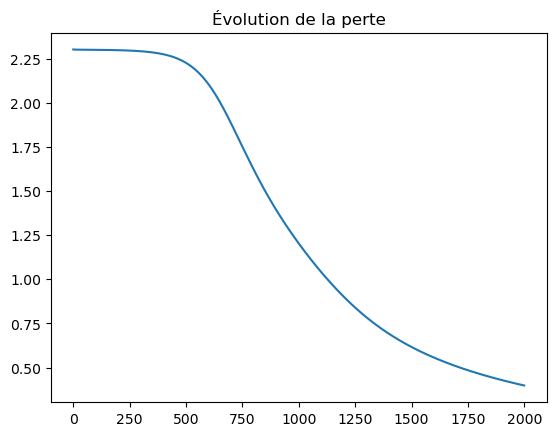

In [8]:
lr=0.1
iteMax=2000
pertes=[]

for ite in range(iteMax):
    a1,a2=forward(X_train,W1,b1,W2,b2)
    l=cross_entropy(y_train,a2)
    pertes.append(l)
    dW1,db1,dW2,db2=backward(X_train,y_train,a1,a2,W2)
    W1-=lr*dW1; b1-=lr*db1
    W2-=lr*dW2; b2-=lr*db2

plt.plot(pertes)
plt.title("Évolution de la perte")
plt.show()


## 5. Évaluation

Nous allons maintenant évaluer l'efficacité du réseau à reconnaître les chiffre présents sur un jeu de données. Pour cela, on calcule les sorties pour un jeu de données (X,y) en entrée. 

Par exemple, si l'image du chiffre 2 est donnée en entrée, on devrait avoir en sortie la réponse y=(0,0,1,0,0,0,0,0,0,0), soit la plus grosse composante de y  en indice 2 (argmax(y)). Il s'agit de la réponse attendue. Si le réseau répond $\hat y = (0.01,0.01,0.91,0.01,0.01,0.01,0.01,0.01,0.01,0.01)$, cela indique que la plus grosse probabilité en sortie est en indice 2 (argmax($\hat y$)).

Le fait que, sur cette image, argmax(y)==argmax($\hat y$) indique que le réseau a bien reconnu le chiffre de l'image. Je rapelle qu'en Python l'expression argmax(y)==argmax($\hat y$) a la valeur 1 (synonyme de True). Il suffit donc de faire la moyenne de ces comparaisons pour l'ensemble du jeu de données fournies au réseau. Une moyenne de 0.9 indiquerait que le réseau reconnait dans 9 cas sur 10.

Un apprentissage n'étant pas parfait, on va comparer la réussite sur le jeu d'entrainement (où le score devrait être élevé) avec celle sur le jeu de test (inconnu du réseau). Si les taux sont comparables on pourra dire que le réseau est assez efficace.

In [19]:
def evaluation_reseau(X,y,W1,b1,W2,b2):
    a1,a2=forward(X,W1,b1,W2,b2)
    return np.mean(np.argmax(a2,axis=1)==np.argmax(y,axis=1))

print("Eval jeu d'apprentissage :",evaluation_reseau(X_train,y_train,W1,b1,W2,b2))
print("Eval jeu de test :",evaluation_reseau(X_test,y_test,W1,b1,W2,b2))

Eval jeu d'apprentissage : 0.9102296450939458
Eval jeu de test : 0.9055555555555556


Voyons sur un exemple particulier du jeu de test :

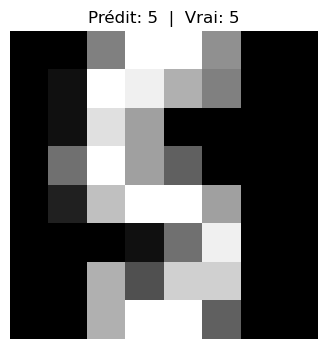

In [18]:
# Choisir un indice dans le jeu test (ex. aléatoire)
idx = np.random.randint(X_test.shape[0])
# idx = 0  # ou fixez un index si vous préférez

# 1) Prédiction du réseau pour cet exemple
_, proba = forward(X_test[idx:idx+1], W1, b1, W2, b2)  # (1,10)
pred_label = int(np.argmax(proba, axis=1)[0])
true_label = int(np.argmax(y_test, axis=1)[idx])       # y_test est one-hot

# 2) Repasser du vecteur (64,) à l'image 8x8
img8 = X_test[idx].reshape(8, 8)

# 3) agrandissement 8x8 -> 64x64
#    np.kron répète chaque pixel 8x8 fois
img64 = np.kron(img8, np.ones((8, 8)))

# 4) Affichage
plt.figure(figsize=(4, 4))
plt.imshow(img64, cmap='gray', vmin=0, vmax=1)
plt.title(f"Prédit: {pred_label}  |  Vrai: {true_label}")
plt.axis('off')
plt.show()